# Exercise 2: Logistic Regression

The [Wisconsin Breast Cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) contains features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. After segmenting cell nuclei present in the image, ten nuclear features were calculated for each cell. These features are modeled such that higher values are typically associated with malignancy. The mean value, worst (mean of the three largest values), and standard error of each feature were computed for each image, resulting in a total of 30 features for each case in the study:

1. radius (mean of distances from center to points on the perimeter)
2. texture (standard deviation of gray-scale values)
3. perimeter
4. area
5. smoothness (local variation in radius lengths)
6. compactness (perimeter^2 / area - 1.0)
7. concavity (severity of concave portions of the contour)
8. concave points (number of concave portions of the contour)
9. symmetry 
10. fractal dimension ("coastline approximation" - 1)

The objective is to determine how points can best be separated into *benign* and *malignant* sets in the case of diagnosis, and into *recurring* and *nonrecurring* sets in the case of prognosis.

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def image_features():
    names = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
             'concavity', 'concave points', 'symmetry', 'fractal dimension']

    columns = ["mean_{}".format(v) for v in names]
    columns.extend(["se_{}".format(v) for v in names])
    columns.extend(["worst_{}".format(v) for v in names])
    return columns


def load_wisconsin_breast_cancer_diagnosis(local_file='datasets/wdbc.data'):
    columns = ['ID', 'diagnosis']
    columns.extend(image_features())

    data = pd.read_csv(local_file, index_col=0, header=None,
                       names=columns, dtype={'diagnosis': 'category'})
    y = data.diagnosis.cat.rename_categories(['benign', 'malignant'])
    X = data.drop('diagnosis', axis=1).astype(float)
    return X, y


def load_wisconsin_breast_cancer_prognosis(local_file='datasets/wpbc.data'):
    columns = ['ID', 'outcome', 'time']
    outcomes = columns[1:]
    extra_vars = ['tumor_size', 'lymph_node_status']
    columns.extend(image_features())
    columns.extend(extra_vars)

    data = pd.read_csv(local_file, index_col=0, header=None,
                       names=columns, dtype={'outcome': 'category'},
                       na_values=['?'])
    y = data.loc[:, outcomes]
    y.outcome.cat.rename_categories(['nonrecurring', 'recurring'], inplace=True)
    X = data.drop(outcomes, axis=1).astype(float)
    return X, y 

## Task 1: Benign vs Malignant

First, we want to classify individual cell nuclei as *benign* or *malignant* based on the 30 features derived from the images.

In [3]:
X_diagnosis, y_diagnosis = load_wisconsin_breast_cancer_diagnosis()

print(X_diagnosis.shape)
print(y_diagnosis.value_counts())

(569, 30)
benign       357
malignant    212
dtype: int64


## Task 2: Recurrence

Next, we want to create a model to predict *recurrence before 24 months* vs. *nonrecurrence beyond 24 months*. The data has two additional features:

1. Tumor size (diameter of the excised tumor in centimeters)
2. Lymph node status (number of positive axillary lymph nodes observed at time of surgery).

**Note:** Lymph node status is missing in 4 cases.

(198, 32)
nonrecurring    151
recurring        47
Name: outcome, dtype: int64


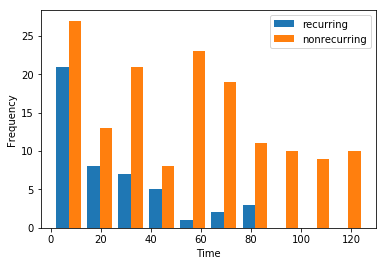

In [4]:
X_prognosis, y_prognosis = load_wisconsin_breast_cancer_prognosis()

print(X_prognosis.shape)
print(y_prognosis.outcome.value_counts())

plt.hist([
    y_prognosis.time[y_prognosis.outcome == 'recurring'],
    y_prognosis.time[y_prognosis.outcome == 'nonrecurring'],
], label=['recurring', 'nonrecurring'])
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.legend()